In [1]:
# TO-DO
# 0) look at data, determine scale of imbalance
# 1) data-reading
# 2) implement k-means treatment
# 3) forest stuff
#
#...
#
# X) understand why self-outcome isn't in top neighbors



In [12]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [4]:
df_raw = pd.read_csv('/home/btannenw/Desktop/life/challenges/ML_Technical/diabetes.csv')

In [106]:
df_raw
df_dropZero = df_raw[ df_raw.Insulin!=0]

In [107]:
def plotOneVariable(_df, varName='', bins=10):
    """ just like what it sounds like"""
    
    plt.hist( _df[varName], bins=bins)
    plt.xlabel(varName)
    plt.show()
    
    return

def calculateCorrelation(_df, varName1='', varName2='', threshold=0.0):
    """ calculate correlation between two variables"""
    
    r = np.corrcoef( _df[varName1], _df[varName2])
    #print(r)
    p = r[0,1]
    
    if np.abs(p) > threshold:
        print("Pearson R ({},{}) = {:.3f}".format(varName1, varName2, r[0,1]))
    
    return

def minMaxScaleVariables(df):
    """return dataframe with variables scaled to [0,1] """
    _df = df.copy()
    
    for variable in _df.columns.to_list():
        if variable == 'Outcome':
            continue
            
        minVal = np.min(_df[variable])
        maxVal = np.max(_df[variable])
        print(variable, minVal, maxVal)
        _df[variable] = _df[variable].apply(lambda x: (x-minVal)/maxVal)
        
    return _df

def standardScaleVariables(df):
    """return dataframe with variables scaled to [0,1] """
    _df = df.copy()
    
    for variable in _df.columns.to_list():
        if variable == 'Outcome':
            continue
            
        meanVal = np.mean(_df[variable])
        stdVal = np.std(_df[variable])
        print(variable, meanVal, stdVal)
        _df[variable] = _df[variable].apply(lambda x: (x-meanVal)/stdVal)
        
    return _df

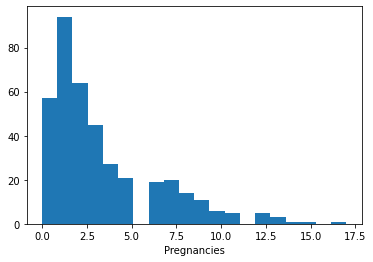

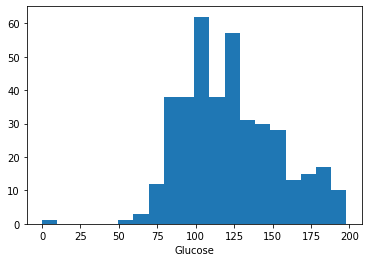

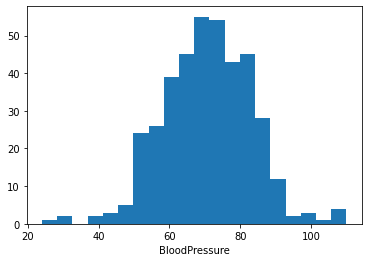

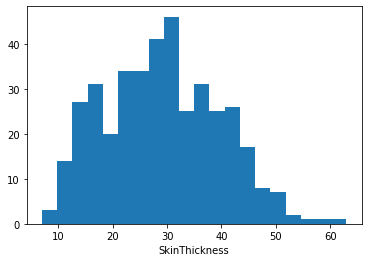

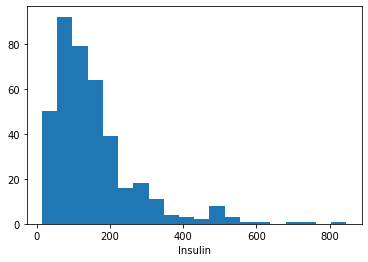

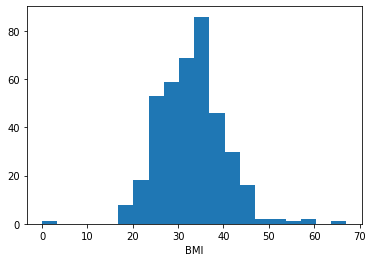

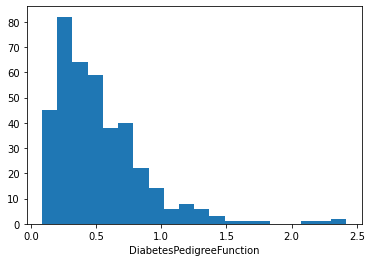

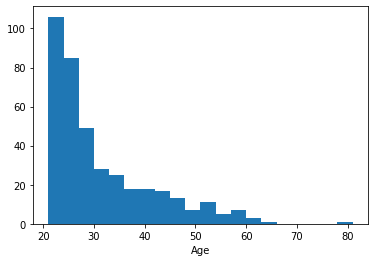

In [108]:
for variable in df_dropZero.columns.to_list():
    if variable != 'Outcome':
        plotOneVariable(df_dropZero, variable, bins=20)

Pregnancies 0 17
Glucose 0 198
BloodPressure 24 110
SkinThickness 7 63
Insulin 14 846
BMI 0.0 67.1
DiabetesPedigreeFunction 0.085 2.42
Age 21 81


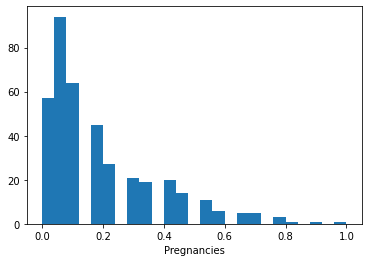

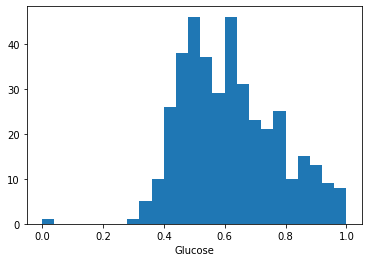

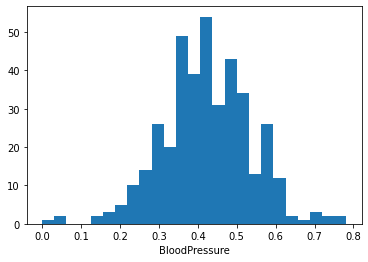

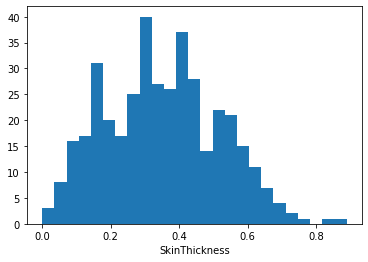

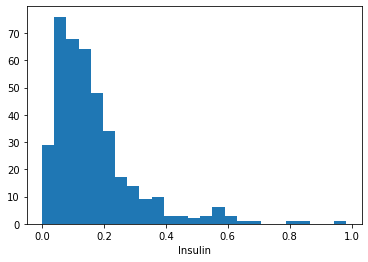

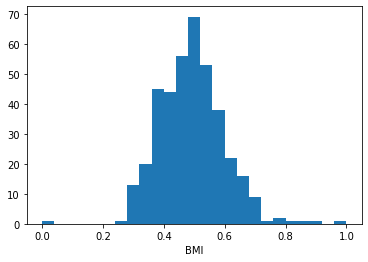

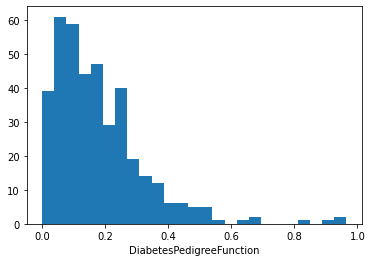

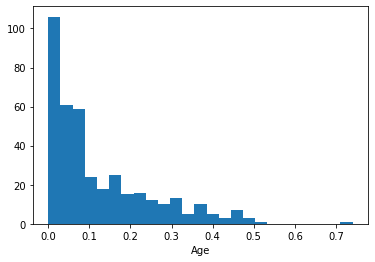

In [109]:
df_minMaxScale = minMaxScaleVariables(df_dropZero)
for variable in df_minMaxScale.columns.to_list():
    if variable != 'Outcome':
        plotOneVariable(df_minMaxScale, variable, bins=25)

Pregnancies 3.286802030456853 3.2055596415650096
Glucose 122.30456852791878 31.356855959690474
BloodPressure 70.65482233502539 12.45408377334157
SkinThickness 29.106598984771573 10.490934307595936
Insulin 155.5482233502538 118.62502864362725
BMI 32.98857868020305 7.201004337041017
DiabetesPedigreeFunction 0.5255431472081219 0.34968234231099693
Age 30.814720812182742 10.186020406620273


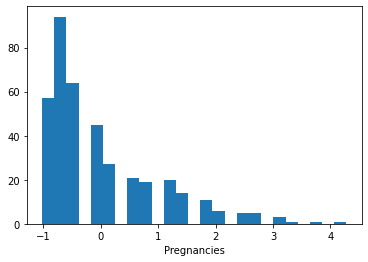

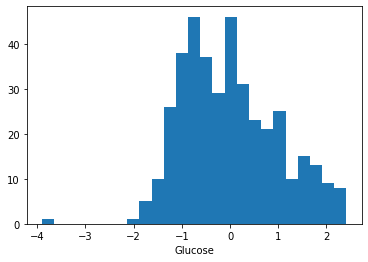

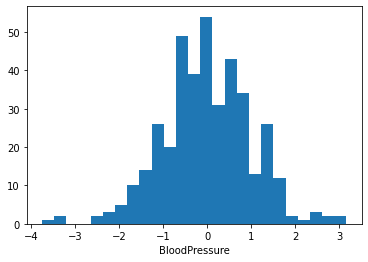

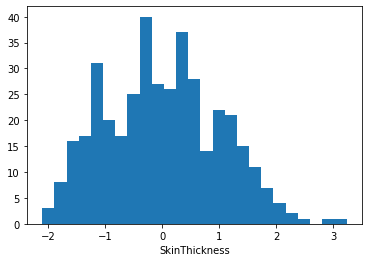

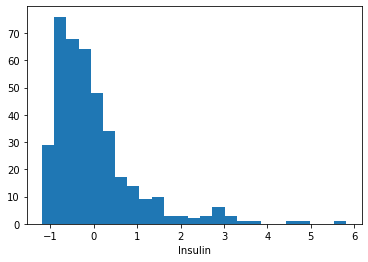

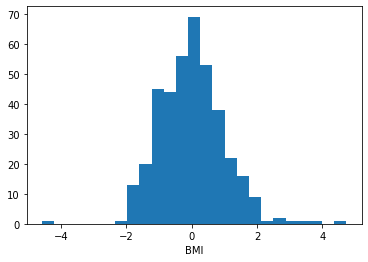

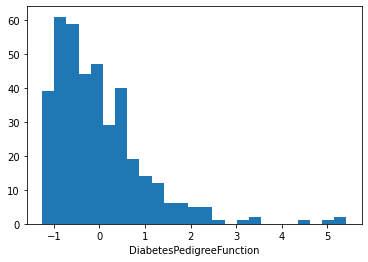

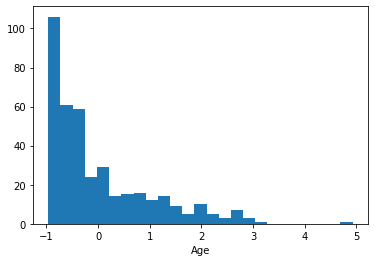

In [111]:
df_standardScale = standardScaleVariables(df_dropZero)
for variable in df_standardScale.columns.to_list():
    if variable != 'Outcome':
        plotOneVariable(df_standardScale, variable, bins=25)

In [50]:
correlationThreshold = 0.3

for var1 in df_raw.columns.to_list():
    if var1 == 'Outcome':
        continue
    for var2 in df_raw.columns.to_list():
        if var2 == 'Outcome':
            continue
            
        if var1 != var2:
            calculateCorrelation(df_dropZero, var1, var2, correlationThreshold)

Pearson R (Pregnancies,Age) = 0.681
Pearson R (Glucose,Insulin) = 0.580
Pearson R (Glucose,Age) = 0.346
Pearson R (BloodPressure,BMI) = 0.302
Pearson R (SkinThickness,BMI) = 0.653
Pearson R (Insulin,Glucose) = 0.580
Pearson R (BMI,BloodPressure) = 0.302
Pearson R (BMI,SkinThickness) = 0.653
Pearson R (Age,Pregnancies) = 0.681
Pearson R (Age,Glucose) = 0.346


In [62]:
print(df_dropZero.Outcome.value_counts())
print("% Positive: {:.3f}".format(130/(264+130)))
calculateCorrelation(df_dropZero, "Outcome", "Insulin")

0    264
1    130
Name: Outcome, dtype: int64
% Positive: 0.330
Pearson R (Outcome,Insulin) = 0.303


In [63]:
print(df_raw.Outcome.value_counts())
print("% Positive: {:.3f}".format(268/(500+268)))
calculateCorrelation(df_raw, "Outcome", "Insulin")

0    500
1    268
Name: Outcome, dtype: int64
% Positive: 0.349
Pearson R (Outcome,Insulin) = 0.131


In [70]:
def returnTestTrainSplit(_df, testingFraction=0.2):
    """takes in dataset, returns testing and training sets split by outcome"""
    
    # Outcome == 1
    _df_outcome1 = _df[_df.Outcome == 1]
    _trainLength = int((1-testingFraction)*len(_df_outcome1))
    
    _train_outcome1 = _df_outcome1[:_trainLength]
    _test_outcome1  = _df_outcome1[_trainLength:]
    print(len(_df_outcome1), _trainLength, len(_train_outcome1), len(_test_outcome1))

    # Outcome == 0
    _df_outcome0 = _df[_df.Outcome == 0]
    _trainLength = int((1-testingFraction)*len(_df_outcome0))
    
    _train_outcome0 = _df_outcome0[:_trainLength]
    _test_outcome0  = _df_outcome0[_trainLength:]
    print(len(_df_outcome0), _trainLength, len(_train_outcome0), len(_test_outcome0))

    return _train_outcome1, _test_outcome1, _train_outcome0, _test_outcome0

In [124]:
train0, test0, train1, test1 = returnTestTrainSplit(df_minMaxScale)

130 104 104 26
264 211 211 53


In [184]:
def returnDistance(testRow, seedRow):
    """ calculate distance and return"""
    
    distance = 0
    
    for variable in testRow.keys().to_list():
        distance += (testRow[variable]-seedRow[variable])**2
    
    return np.sqrt(distance)

def applyNeighborDistance(seedRow, df):
    """add column of distance to original point"""
    _df = df.copy()
    
    _df['neighborDistance'] = _df.apply( lambda x: returnDistance(x, seedRow), axis=1)
    
    return _df
    

def buildCriticalSet( _train0, _train1, k=5):
    """ build critical set using k-nearest neighbor algorithm"""
    
    _Tc = _train1.copy()
    _T = _train0.copy()
    _T = _T.append(_train1.copy())
    
    for iRow in range(0, len(_T)):
        if _T.iloc[iRow].Outcome == 1:
            # calculate distance for selected rows and apply as new column
            _tempT = applyNeighborDistance( _T.iloc[iRow], _T)
            # keep the top 6 (includes self + top5)
            _tempTop6 = _tempT.nsmallest(k+1, 'neighborDistance')
            _tempTop6 = _tempTop6.drop(columns=['neighborDistance'])
            print(iRow, _tempTop6)
            
            print("a, ", len(_Tc))
            # add top to critical set
            _Tc = _Tc.append(_tempTop6)
            print("b, ", len(_Tc))
            
            # drop duplicates
            _Tc.drop_duplicates(keep='first', inplace=True)
            #_Tc.drop_duplicates(keep='first', inplace=True)
            print("c, ", len(_Tc))

    return _Tc


In [185]:
buildCriticalSet(train0, train1, 5)

0      Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
4       0.000000  0.691919       0.145455       0.444444  0.182033  0.642325   
308     0.000000  0.646465       0.400000       0.190476  0.196217  0.454545   
292     0.117647  0.646465       0.490909       0.476190  0.198582  0.645306   
356     0.058824  0.631313       0.236364       0.523810  0.180851  0.496274   
370     0.176471  0.873737       0.527273       0.650794  0.533097  0.572280   
243     0.352941  0.601010       0.236364       0.238095  0.191489  0.403875   

     DiabetesPedigreeFunction       Age  Outcome  
4                    0.910331  0.148148        1  
308                  0.539669  0.049383        1  
292                  0.470661  0.123457        1  
356                  0.362397  0.086420        1  
370                  0.847934  0.049383        1  
243                  0.509504  0.148148        1  
a,  211
b,  217
c,  217
1      Pregnancies   Glucose  BloodPressure  SkinThickne

10      Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
39      0.235294  0.560606       0.436364       0.634921  0.228132  0.552906   
292     0.117647  0.646465       0.490909       0.476190  0.198582  0.645306   
539     0.176471  0.651515       0.618182       0.666667  0.166667  0.542474   
540     0.470588  0.505051       0.454545       0.523810  0.237589  0.587183   
198     0.235294  0.550505       0.363636       0.587302  0.100473  0.518629   
458     0.588235  0.747475       0.545455       0.650794  0.263593  0.560358   

     DiabetesPedigreeFunction       Age  Outcome  
39                   0.539256  0.432099        1  
292                  0.470661  0.123457        1  
539                  0.364876  0.135802        1  
540                  0.238017  0.271605        1  
198                  0.338843  0.061728        1  
458                  0.378512  0.370370        1  
a,  260
b,  266
c,  264
11      Pregnancies   Glucose  BloodPressure  SkinThick

20      Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
114     0.411765  0.808081       0.272727       0.396825  0.190307  0.454545   
175     0.470588  0.904040       0.436364       0.555556  0.137116  0.487332   
171     0.352941  0.676768       0.418182       0.253968  0.137116  0.527571   
338     0.529412  0.767677       0.490909       0.428571  0.185579  0.509687   
360     0.294118  0.954545       0.363636       0.412698  0.367612  0.464978   
424     0.470588  0.762626       0.490909       0.396825  0.231678  0.639344   

     DiabetesPedigreeFunction       Age  Outcome  
114                  0.207851  0.222222        1  
175                  0.261983  0.185185        1  
171                  0.188843  0.098765        1  
338                  0.333884  0.148148        1  
360                  0.205785  0.098765        1  
424                  0.178099  0.185185        1  
a,  283
b,  289
c,  286
21      Pregnancies   Glucose  BloodPressure  SkinThick

30      Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
175     0.470588  0.904040       0.436364       0.555556  0.137116  0.487332   
338     0.529412  0.767677       0.490909       0.428571  0.185579  0.509687   
545     0.470588  0.939394       0.600000       0.444444  0.249409  0.514158   
114     0.411765  0.808081       0.272727       0.396825  0.190307  0.454545   
424     0.470588  0.762626       0.490909       0.396825  0.231678  0.639344   
56      0.411765  0.944444       0.400000       0.507937  0.342790  0.561848   

     DiabetesPedigreeFunction       Age  Outcome  
175                  0.261983  0.185185        1  
338                  0.333884  0.148148        1  
545                  0.139669  0.197531        1  
114                  0.207851  0.222222        1  
424                  0.178099  0.185185        1  
56                   0.069835  0.246914        1  
a,  298
b,  304
c,  298
31      Pregnancies   Glucose  BloodPressure  SkinThick

40      Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
206     0.470588  0.989899       0.472727       0.349206  0.314421  0.558867   
53      0.470588  0.888889       0.600000       0.428571  0.338061  0.502235   
236     0.411765  0.914141       0.545455       0.222222  0.210402  0.535022   
546     0.294118  0.944444       0.472727       0.317460  0.228132  0.649776   
603     0.411765  0.757576       0.490909       0.349206  0.132388  0.524590   
56      0.411765  0.944444       0.400000       0.507937  0.342790  0.561848   

     DiabetesPedigreeFunction       Age  Outcome  
206                  0.214876  0.444444        1  
53                   0.157851  0.456790        1  
236                  0.207025  0.370370        1  
546                  0.392149  0.395062        1  
603                  0.250826  0.407407        1  
56                   0.069835  0.246914        1  
a,  303
b,  309
c,  304
41      Pregnancies   Glucose  BloodPressure  SkinThick

50      Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
259     0.647059  0.782828       0.472727       0.333333  0.160757  0.496274   
152     0.529412  0.787879       0.563636       0.333333  0.166667  0.511177   
516     0.529412  0.732323       0.581818       0.428571  0.178487  0.451565   
338     0.529412  0.767677       0.490909       0.428571  0.185579  0.509687   
603     0.411765  0.757576       0.490909       0.349206  0.132388  0.524590   
323     0.764706  0.767677       0.600000       0.412698  0.017730  0.399404   

     DiabetesPedigreeFunction       Age  Outcome  
259                  0.523967  0.370370        1  
152                  0.456198  0.259259        1  
516                  0.283471  0.395062        1  
338                  0.333884  0.148148        1  
603                  0.250826  0.407407        1  
323                  0.266942  0.271605        1  
a,  309
b,  315
c,  309
51      Pregnancies   Glucose  BloodPressure  SkinThick

60      Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
309     0.117647  0.626263       0.400000       0.333333  0.225768  0.490313   
326     0.058824  0.616162       0.363636       0.396825  0.167849  0.523100   
541     0.176471  0.646465       0.436364       0.285714  0.208038  0.482861   
19      0.058824  0.580808       0.418182       0.365079  0.096927  0.515648   
70      0.117647  0.505051       0.381818       0.206349  0.089835  0.490313   
31      0.176471  0.797980       0.472727       0.460317  0.273050  0.470939   

     DiabetesPedigreeFunction       Age  Outcome  
309                  0.326446  0.111111        1  
326                  0.250826  0.111111        1  
541                  0.191736  0.074074        1  
19                   0.183471  0.135802        1  
70                   0.323140  0.086420        1  
31                   0.316529  0.086420        1  
a,  311
b,  317
c,  311
61      Pregnancies   Glucose  BloodPressure  SkinThick

70      Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
370     0.176471  0.873737       0.527273       0.650794  0.533097  0.572280   
292     0.117647  0.646465       0.490909       0.476190  0.198582  0.645306   
220     0.000000  0.893939       0.327273       0.349206  0.548463  0.515648   
4       0.000000  0.691919       0.145455       0.444444  0.182033  0.642325   
409     0.058824  0.868687       0.400000       0.666667  0.667849  0.631893   
31      0.176471  0.797980       0.472727       0.460317  0.273050  0.470939   

     DiabetesPedigreeFunction       Age  Outcome  
370                  0.847934  0.049383        1  
292                  0.470661  0.123457        1  
220                  0.407851  0.000000        1  
4                    0.910331  0.148148        1  
409                  0.254959  0.086420        1  
31                   0.316529  0.086420        1  
a,  313
b,  319
c,  313
71      Pregnancies   Glucose  BloodPressure  SkinThick

80      Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
427     0.058824  0.914141       0.363636       0.365079  0.196217  0.508197   
132     0.176471  0.858586       0.363636       0.476190  0.249409  0.514158   
561     0.000000  1.000000       0.381818       0.396825  0.307329  0.615499   
110     0.176471  0.863636       0.436364       0.412698  0.143026  0.496274   
480     0.176471  0.797980       0.418182       0.365079  0.371158  0.529061   
301     0.117647  0.727273       0.309091       0.412698  0.143026  0.470939   

     DiabetesPedigreeFunction       Age  Outcome  
427                  0.100413  0.209877        1  
132                  0.111983  0.111111        1  
561                  0.172314  0.086420        1  
110                  0.047107  0.037037        1  
480                  0.107025  0.172840        1  
301                  0.139256  0.049383        1  
a,  313
b,  319
c,  313
81      Pregnancies   Glucose  BloodPressure  SkinThick

89      Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
498     0.411765  0.984848       0.418182       0.412698  0.154846  0.374069   
306     0.588235  0.813131       0.400000       0.253968  0.139480  0.380030   
206     0.470588  0.989899       0.472727       0.349206  0.314421  0.558867   
56      0.411765  0.944444       0.400000       0.507937  0.342790  0.561848   
53      0.470588  0.888889       0.600000       0.428571  0.338061  0.502235   
236     0.411765  0.914141       0.545455       0.222222  0.210402  0.535022   

     DiabetesPedigreeFunction       Age  Outcome  
498                  0.032231  0.419753        1  
306                  0.099587  0.320988        1  
206                  0.214876  0.444444        1  
56                   0.069835  0.246914        1  
53                   0.157851  0.456790        1  
236                  0.207025  0.370370        1  
a,  314
b,  320
c,  314
90      Pregnancies   Glucose  BloodPressure  SkinThick

99      Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
569     0.000000  0.611111       0.381818       0.365079  0.178487  0.511177   
19      0.058824  0.580808       0.418182       0.365079  0.096927  0.515648   
326     0.058824  0.616162       0.363636       0.396825  0.167849  0.523100   
213     0.000000  0.707071       0.372727       0.301587  0.137116  0.634873   
419     0.176471  0.651515       0.363636       0.349206  0.119385  0.393443   
301     0.117647  0.727273       0.309091       0.412698  0.143026  0.470939   

     DiabetesPedigreeFunction       Age  Outcome  
569                  0.048760  0.148148        1  
19                   0.183471  0.135802        1  
326                  0.250826  0.111111        1  
213                  0.142975  0.037037        1  
419                  0.055372  0.086420        1  
301                  0.139256  0.049383        1  
a,  315
b,  321
c,  315
100      Pregnancies   Glucose  BloodPressure  SkinThic

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
3,0.058824,0.449495,0.381818,0.253968,0.094563,0.418778,0.033884,0.000000,0
18,0.058824,0.520202,0.054545,0.492063,0.081560,0.645306,0.040496,0.148148,0
20,0.176471,0.636364,0.581818,0.539683,0.261229,0.585693,0.255785,0.074074,0
27,0.058824,0.489899,0.381818,0.126984,0.148936,0.345753,0.166116,0.012346,0
28,0.764706,0.732323,0.527273,0.190476,0.113475,0.330849,0.066116,0.444444,0
...,...,...,...,...,...,...,...,...,...
498,0.411765,0.984848,0.418182,0.412698,0.154846,0.374069,0.032231,0.419753,1
595,0.000000,0.949495,0.527273,0.111111,0.202128,0.476900,0.246694,0.012346,1
506,0.000000,0.909091,0.600000,0.301587,0.089835,0.543964,0.094628,0.172840,1
445,0.000000,0.909091,0.490909,0.888889,0.000000,0.885246,0.964876,0.049383,1


In [129]:
returnDistance( train0.iloc[10], train0.iloc[12])

0.6270734512881457

In [180]:
test2 = train1.copy()
test2 = test2.append(train0.copy())

test1 = applyNeighborDistance(train1.iloc[0], test2)
test1

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,neighborDistance
3,0.058824,0.449495,0.381818,0.253968,0.094563,0.418778,0.033884,0.000000,0,0.000000
18,0.058824,0.520202,0.054545,0.492063,0.081560,0.645306,0.040496,0.148148,0,0.492211
20,0.176471,0.636364,0.581818,0.539683,0.261229,0.585693,0.255785,0.074074,0,0.529867
27,0.058824,0.489899,0.381818,0.126984,0.148936,0.345753,0.166116,0.012346,0,0.209008
28,0.764706,0.732323,0.527273,0.190476,0.113475,0.330849,0.066116,0.444444,0,0.900060
...,...,...,...,...,...,...,...,...,...,...
569,0.000000,0.611111,0.381818,0.365079,0.178487,0.511177,0.048760,0.148148,1,1.039074
584,0.470588,0.626263,0.472727,0.269841,0.692671,0.427720,0.248760,0.382716,1,1.326563
588,0.176471,0.888889,0.563636,0.317460,0.167849,0.496274,0.441736,0.382716,1,1.252273
595,0.000000,0.949495,0.527273,0.111111,0.202128,0.476900,0.246694,0.012346,1,1.164223


In [181]:
test1.nsmallest(6, 'neighborDistance')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,neighborDistance
3,0.058824,0.449495,0.381818,0.253968,0.094563,0.418778,0.033884,0.000000,0,0.000000
208,0.058824,0.484848,0.363636,0.317460,0.086288,0.494784,0.084298,0.000000,0,0.118315
158,0.117647,0.444444,0.454545,0.190476,0.046099,0.432191,0.059504,0.012346,0,0.127057
553,0.058824,0.444444,0.345455,0.269841,0.035461,0.445604,0.139256,0.024691,0,0.132383
334,0.058824,0.479798,0.327273,0.174603,0.052009,0.356185,0.072314,0.012346,0,0.132477
103,0.058824,0.409091,0.436364,0.174603,0.030733,0.396423,0.081818,0.037037,0,0.138383
